In [128]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin

import scipy
import scipy.signal
from scipy import signal
from scipy.io.wavfile import write
from scipy.linalg import hankel
from scipy.linalg import toeplitz
from scipy.signal import lfilter

from numpy.linalg import pinv

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

import matplotlib.pyplot as plt
import numpy as np

import wave

import colorednoise as cn
#from matplotlib import pylab as plt

import sounddevice as sd
from scipy.io.wavfile import write


# %matplotlib widget
%matplotlib inline

In [2]:
def nextpow2(i):
    n = 1
    while n < i:
        n *= 2
    return n

> ## Signal Treatment

> Pre-emphasis

In [3]:
def preemphasize(sig : np.ndarray, b = np.array([1, -0.95])):
    # input
        # sig: the input signal
        # b = = np.array([1, -0.95]) # coefficients recommended by the prof, change if needed
        N = len(sig)
        Nfft = nextpow2(N)

        a = np.ones(2)
        preemph_sig = signal.lfilter(b, a, sig)

        PSD_sig, freq = plt.psd(sig, )
        PSD_preemph_sig, _ =  plt.psd(preemph_sig, Nfft)

        return preemph_sig, freq, PSD_sig, PSD_preemph_sig

> Decimation and Bank Filters

In [4]:
center_freqs = np.arange(100, 3000, 100) # à nous de définir selon le signal
def filter_bank(sig : np.ndarray, center_freqs : np.ndarray, fe : float):
    #input
       #sig
       #center_freqs : centered frequencies in filter banks
       #fe : sampling frequency


    #filter banks
    #PSD_sig = plt.psd(sig)
    nb_bands = len(center_freqs)
    #crossover_gain = 10**(-3/20) # cross at -3db of gain for the adjacent bands

    #band edges, frequencies
    band_edges = np.zeros((nb_bands,2))
    #band_edges [:,0] = center_freqs -  
    #band_edges [:,1] = center_freqs +   

    h = [] #impulse response 
    sig_list = []  #Roy: I suggest that we use an numpy array
    for i in range(nb_bands):
       b, a = signal.butter(nb_bands, [band_edges[i,0],band_edges[i,1]], btype = 'bandpass',analog=False, fs=fe,output='SOS')
       #w, H = signal.sosfreqz(h[i], worN=2000,fs=fe)  #Compute the frequency response of a digital filter in SOS format     
       sig_list.append(lfilter(b, a, sig))
   
    return sig_list

ALTERNATIVE: Use signal.stft which is equivalent to a filter bank + decimation (see the test codes below).

PS: After applying the filter bank, the signal is denoted by "x" insteasd of "sig".

> Noise whitening algorithm

In [176]:
# (can be applied to the original signal and also to the signals filtered with subbands)
def whiten(x : np.ndarray, smoothing_order : int, AR_order : int): # add input??
    # input
        # x: the input signal FOR EACH FREQUENCY BAND
        # smoothing_order: at least two times the length of the PSD's principal lobe (can be done visually)
        # AR_order: ~ 10
    
    N = len(x)
    Nfft = nextpow2(N)
    
    # Step 1: signal's power spectral density
    freq, PSD_x = signal.welch(x, nfft = Nfft) #return_onesided = False
    #PSD_x, freq = plt.psd(x, Nfft)


    # Step 2: estimating the noise's PSD with a median filter (smoothing the signal's PSD)
    b = (np.ones(smoothing_order))/smoothing_order  # numerator co-effs of the filter's transfer function
                                                    # denominator co-eff of the filter's transfer function is 1
    PSD_noise = signal.lfilter(b, [1], PSD_x)       # smoothed PSD = estimation of the noise PSD

    # Step 3: calculating the autocovariance of the noise
    AC = np.abs(np.fft.ifft(PSD_noise, Nfft))                     # autocovariance (vector) of the noise
    print(AC)
    R = toeplitz(AC[:AR_order-1],AC[:AR_order-1])   # coefficients matrix of the Yule-Walker system
                                                    # = autocovariance matrix with the last row and last column removed
    r = AC[1:AR_order].T               # the constant column of the Yule-Walker system
    B = - pinv(R) @ r           # the AR coefficients (indices 1, ..., N-1)
    B = np.insert(B, 0, 1)      # the AR coefficients (indices 0, ..., N-1)

    # Step 4: applying the corresponding FIR to the signal's PSD to obtain the whitened signal
    # The FIR is the inverse of the AR filter so the coefficients of the FIR's numerator
    # are the coefficients of the AR's denominator, i.e. the array B
    # denominator co-eff of the FIR's transfer function is 1
    x_white = signal.lfilter(B, [1], x)

    # Step 5: re-estimating the noise, now for the white signal
    _, PSD_x_white = signal.welch(x_white, nfft = Nfft)
    #PSD_x_white, freq = plt.psd(x_white, Nfft)
    PSD_noise_white = signal.lfilter(b, [1], PSD_x_white)

    return x_white, freq, PSD_x, PSD_noise, PSD_x_white, PSD_noise_white

> ## ESPRIT

In [6]:
def ESPRIT(x : np.ndarray, n : int, K : int):
    # input
        # x: input signal
        # n: number of lines in the Hankel matrix S
        # and signal space basis W
        # K: order of signal

        # (n-K : noise space dimension)

    # output
        # delta: array of damping factors
        # f: array of frequencies

    N = len(x)          # signal's length
    l = N - n + 1       # number of columns of the Hankel matrix
                        # Not needed for the 'hankel' function but used in the formula of R_XX  

    X = hankel(x[:n], x[n-1:])      # Hankel matrix

    R_XX = 1/l * X @ X.conj().T             # correlation matrix
    U1, Lambda, U2 = np.linalg.svd(R_XX)
    W = U1[:n, :K]                          # signal space matrix
    
    W_down = W[:-1]
    W_up = W[1:]
    phi = (np.linalg.pinv(W_down)) @ W_up
    eigenvalues, eigenvectors = np.linalg.eig(phi)
    
    delta = np.log(np.abs(eigenvalues))         # damping factors
    f = (1/(2*np.pi)) * np.angle(eigenvalues)   # frequencies

    return delta, f


> ## Least Squares

In [7]:
def LeastSquares(x : np.ndarray, delta : np.ndarray, f : np.ndarray):
    # input
        # x: input signal
        # delta: array of damping factors
        # f: array of frequencies

    # output
        # alpha: array of complex amplitudes
        # a: array of real amplitudes
        # phi: array of initial phases

    N = len(x)                  # signal's length
    t = np.arange(N)            # array of discrete times
    s = delta + 2j*np.pi*f      # log of the pole
    VN = np.exp(np.outer(t,s))  # Vandermonde matrix of dimension N
    
    alpha = np.linalg.pinv(VN)@x
    a = abs(alpha)
    phi = np.angle(alpha)
    
    return alpha, a, phi

> ## Energy

In [8]:
def Energy(x: np.ndarray, delta: np.ndarray, a: np.ndarray):
    # input
        # x: input signal
        # delta: array of damping factors
        # a: array of real amplitudes

    # output
        # EdB: array of energies

    
    N = len(x)              # signal's length
    times = np.arange(N)    # array of discrete times

    K = len(delta)          # number of sinusoids
    E = np.zeros(K)

    for k in range(K):      # calculating the energy of each sinusoid
        e_k = 0
        for t in times:
            e_k += np.exp(2*delta[k]*t)     # the contribution of delta
        E[k] = a[k]**2 * e_k                # the energy of the kth sinusoid

    Emax = max(E)
    EdB = 10*np.log(E/Emax)     # Energy in dB

    return EdB


> ## ESTER

In [9]:
def ESTER(x : np.ndarray, n : int, K : int):
    # x: input signal
    # n: n: number of lines in the Hankel matrix S
    # K: ?

    # calculating the inverse error function
    N = len(x)
    l = N-n+1
    X = hankel(x[:n], x[n-1:N])
    XH = X.conj().T
    Rxx = 1/l*X*XH
    U1, lam, U =  np.linalg.svd(Rxx)
    norm_E = []
    for i in range(K):
        W = U1[: n, :i]
        W_down = W[0:n-1,:]
        W_up = W[1:n,:]
        Phi = np.dot(np.linalg.pinv(W_down),(W_up))
        E = W_up - np.dot(W_down, Phi)
        Valeur,_,_ = np.linalg.svd(E)
        norm_E = max(Valeur)  # not sure here
    return norm_E

> ## ESPRIT BY BLOCKS
(Contains ESPRIT, LeastSquares, and Energy)

In [10]:
def blocks(x_full : np.ndarray, window_length : float, hop_size : float, sampling_rate : int, n : int, K : int): ##par bloque
    # input
        # x_full: the full-length input signal
        # window_length: the window size (in seconds)
        # hop_size: the hop size (in seconds)
        # n: number of lines in the Hankel matrix S
        # and signal space basis W
        # K: the number of sinusoids

    N_full = len(x_full)                    # the length of the signal (in samples)
    N = int(window_length*sampling_rate)    # window size (in samples)
    h = int(hop_size*sampling_rate)         # hope size (in samples)
    I = int((N_full-N)/h)

    delta = f = alpha = a = phi = EdB = np.zeros(I)

    for i in range(I):

        x_i = x_full[i:i+h]     # ith truncated signal

        delta[i], f[i] = ESPRIT(x_i, n, K)
        alpha[i], a[i], phi[i] = LeastSquares(x_i, delta[i], f[i])
        EdB[i] = Energy(x[i], delta[i], a[i])

    return delta, f, alpha, a, phi, EdB

> ## Signal Synthesis

> Synthesis Function(s)

In [11]:
def Synthesis(N: int, delta: np.ndarray, f: np.ndarray, a: np.ndarray, phi : np.ndarray, noisy = False):
    # N: length of the signal (discrete)
    # delta: array of damping factors
    # f: array of normalized frequencies
    # a: array of real amplitudes
    # phi: array of initial phases
    # noisy: set to True if a noisy signal is desired 

    t = range(N)                    #time range
    logz = delta + 1j*2*np.pi*f     #log of poles
    alpha = a*np.exp(1j*phi)        #complex amplitudes
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz, t)), axis=0)  #noisless signal (ESM)
    
    else:   #synthesizing noise
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-noisy/20) #This is from TP HR. Isn't noisy equal to 1 in this case? Maybe this was originally meant to be a general formula without an if statement?
        s = x+b     #noisy signal
    return s

Tremolo Synthesis

In [617]:
# This function synthesizes a sinusoidal signal, with set frequencies, amplitudes, initial phases, and damping factors
# with optional tremolo effect (FM) and noise (white, pink, or red)

def synthesize(N: int, delta: np.ndarray, f: np.ndarray, a: np.ndarray, phi : np.ndarray, f_m : float, mod_index : float, noise_index : int, sin_to_noise : int):
    # input
        # N: length of the signal (discrete)
        # delta: array of damping factors
        # f: array of normalized frequencies
        # a: array of real amplitudes
        # phi: array of initial phases
        # f_m: modulating frequency (FM)
        # mod_index: modulation index (0 if tremolo is not desired)
        # noise index:
            # 0: noiseless
            # 1: white noise
            # 2: pink noise
            # 3: red noise

    t_array = np.arange(N)          #time array
    logz = delta + 1j*2*np.pi*f     #log of poles
    alpha = a*np.exp(1j*phi)        #complex amplitudes

    mod = np.exp(1j*mod_index*np.sin(2*np.pi*f_m*t_array))  # modulation component

    sinusoids = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz, t_array)), axis=0)  #noisless signal (ESM)
    sinusoids = sinusoids*mod # modulated signal

    if noise_index == 0:
        noise = np.zeros(N)
        SNR = '-oo'
        x = sinusoids

    else: 
        noise = cn.powerlaw_psd_gaussian(noise_index-1, N)    # synthesizing noise

        # normalaizing the noise according to a sinusoids-to-noise ratio (in dB)
        norm = np.exp(-(1/20)*(sin_to_noise + 10*np.log10(np.sum(noise**2)) - 10*np.log(np.sum(np.real(sinusoids)**2))))
        noise = norm*noise
        x = sinusoids + noise
        SNR = 10*np.log(np.sum(np.real(x)**2)) - 10*np.log10(np.sum(noise**2))
    
    return x, sinusoids, noise, SNR

In [618]:
N_trem0 = 2**9-1

delta_trem0 = np.array([0])

f_trem0 = np.array([0.05])

a_trem0 = np.array([0.1])

phi_trem0 = np.array([0])

tremolo0 = synthesize(N_trem0, delta_trem0, f_trem0, a_trem0, phi_trem0, 0.01, 2, 0, 0)

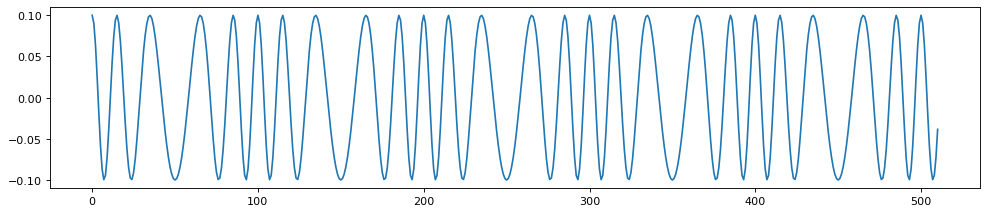

In [619]:
plt.figure(figsize=(15, 3), dpi=80)

plt.plot(np.real(tremolo0[0]))
plt.show()


In [620]:
N_trem1 = 2**11-1

K_trem1 = 8

f0 = 0.06
f_trem1 = f0*np.arange(1,K_trem1+1)

a_trem1 = np.array([0.00807193, 0.09748246, 0.02404544, 0.04275309, 0.02482811,
       0.08778044, 0.00470351, 0.03118916])

delta_trem1 = -0.0001*np.random.rand(K_trem1)

phi_trem1 = np.array([1.76348603, 1.20411769, 0.76158339, 1.35157899, 0.36247392,
       1.44086579, 1.73647764, 1.98131046])

tremolo1 = synthesize(N_trem1, delta_trem1, f_trem1, a_trem1, phi_trem1, 0.003, 10, 0, 0)

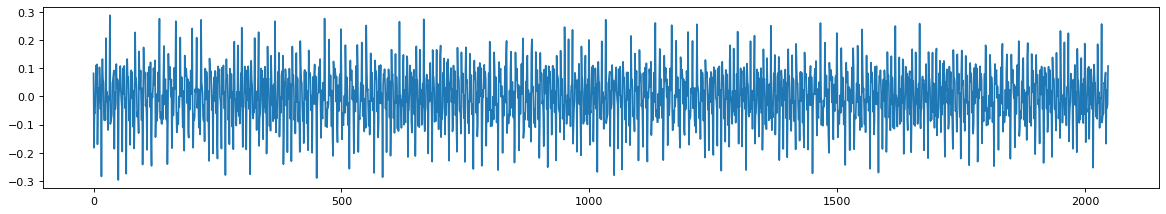

In [621]:
plt.figure(figsize=(18, 3), dpi=80)

plt.plot(np.real(tremolo1[0]))

plt.show()

In [622]:
fs1 = 1000

sd.play(np.real(tremolo1[0]), fs1)

print("The length of the signal is", N_trem1/fs1, "seconds.")

t = np.linspace(0., N_trem0/fs1, fs1)
amplitude = np.iinfo(np.int16).max
data  = amplitude*np.real(tremolo1[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("tremolo.wav", fs1, data.astype(np.int16))

The length of the signal is 2.047 seconds.


In [623]:
blocks(np.real(tremolo0), 0.1, 0.075, fs, 4, 8)

C:\Users\royal\anaconda3\envs\env_pam_hr\lib\site-packages\numpy\lib\type_check.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(val).real


ZeroDivisionError: division by zero

> Synthesised Signals

Simple Noisless Signal with Two Sinusoids

8.84656282057143

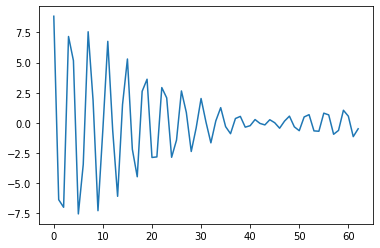

In [624]:
N_synth = 63

f0_synth = 1/4
f_synth = np.array([f0_synth, f0_synth+(1/N_synth)])

a_synth = np.array([1, 10])

delta_synth = np.array([0, -0.05])

phi_synth = np.array([1.5, 0.5])

# synthesised signal
x_synth = Synthesis(N_synth, delta_synth, f_synth, a_synth, phi_synth)

plt.plot(np.real(x_synth))

np.max(np.real(x_synth))

SNR = 101.15460305945192 dB


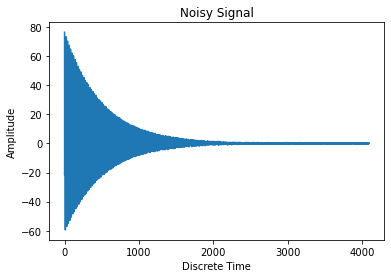

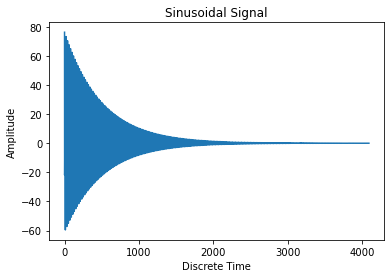

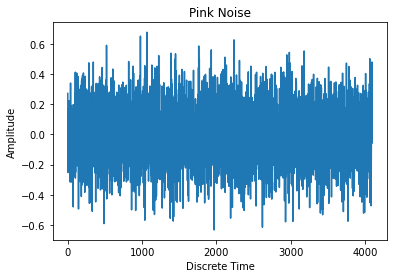

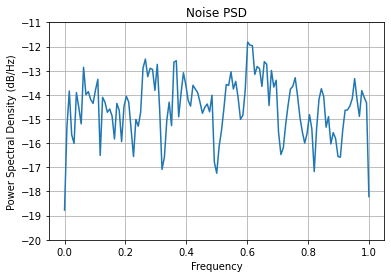

In [652]:
N_synth1 = 2**12-1

K_synth1 = 8

f_synth1 = 0.05*np.arange(1,K_trem1+1)

a_synth1 = np.array([18, 17, 16, 15, 14, 13, 12, 11])

delta_synth1 = -0.002*np.ones([K_synth1])

phi_synth1 = np.array([0, 1.5, 0, 1, 0, 1.5, 0, 1])

# synthesised signal
x_synth1 = synthesize(N_synth1, delta_synth1, f_synth1, a_synth1, phi_synth1, 0, 0, 1, 120)

print("SNR =", x_synth1[3], "dB")

plt.figure()
plt.plot(np.real(x_synth1[0]))
plt.title('Noisy Signal')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
#plt.xlim(250,3000)
plt.show()

plt.figure()
plt.plot(np.real(x_synth1[1]))
plt.title('Sinusoidal Signal')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
#plt.xlim(250,3000)
plt.show()

plt.figure()
plt.plot(x_synth1[2])
plt.title('Pink Noise')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
plt.show()


plt.figure()
plt.title("Noise PSD")
plt.psd(x_synth1[2])
plt.show()


In [653]:
fs2 = 1000

sd.play(np.real(x_synth1[0]), fs2)

print("The length of the signal is", N_synth1/fs2, "seconds.")

t = np.linspace(0., N_synth1/fs2, fs2)
amplitude = 0.01*np.iinfo(np.int16).max
data  = amplitude*np.real(x_synth1[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("noisy.wav", fs2, data.astype(np.int16))

The length of the signal is 4.095 seconds.


> ### Sub-bands

In [ ]:
fs = 1.0
window_name ='hann'
n_fft = 16
m = 100 # n_fft // 2 # window length
step = 75

freqs_x, times_x, x_arr = signal.stft(np.real(x_synth1[:500]), fs=fs, window=window_name,
    nperseg=m, nfft=n_fft)
times_sig = np.arange(N_synth1) * fs

[25.46539316 19.80554893  8.06095967 ...  5.06686313  8.06095967
 19.80554893]


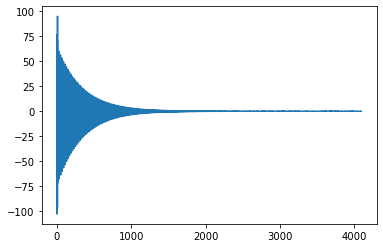

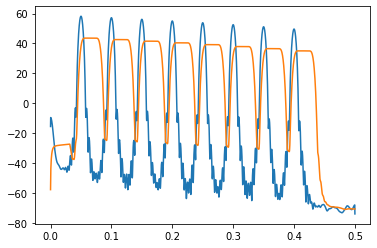

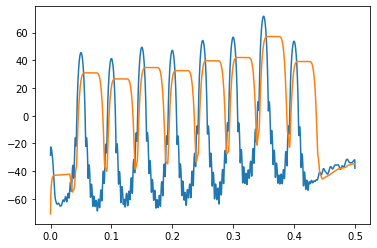

In [499]:
x_white1, freq1, PSD_x1, PSD_noise1, PSD_x_white1, PSD_noise_white1 = whiten(np.real(x_synth1[0]), 130, 10)

plt.figure()

plt.plot(np.arange(N_synth1), x_white1)

plt.show()

plt.figure()

plt.plot(freq1, 20*np.log10(np.abs(PSD_x1)))

plt.plot(freq1, 20*np.log10(np.abs(PSD_noise1)))

plt.show()

plt.figure()

plt.plot(freq1, 20*np.log10(np.abs(PSD_x_white1)))

plt.plot(freq1, 20*np.log10(np.abs(PSD_noise_white1)))

plt.show()



> Verification of EPRIT (classic)

In [25]:
delta_an, f_an = ESPRIT(x_synth, 32, 2)

alpha_an, a_an, phi_an = LeastSquares(x_synth, delta_an, f_an)

EdB_an = Energy(x_synth, delta_an, a_an)

print(delta_an, f_an, alpha_an, a_an, phi_an, EdB_an)


[-5.00000000e-02 -1.11022302e-16] [0.26587302 0.25      ] [8.77582562+4.79425539j 0.0707372 +0.99749499j] [10.  1.] [0.5 1.5] [  0.         -28.12365928]


In [26]:
2**10 *0.04 *2

81.92

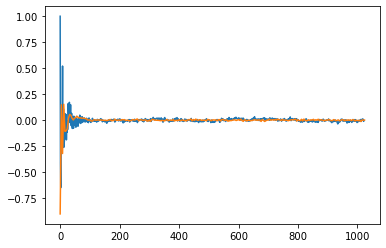

In [29]:
k = 6 # n# of band
plt.plot(times_sig, sig / np.max(np.abs(sig)))
plt.plot(times_x, np.real(x_arr[k]) / np.max(np.abs(x_arr)))
plt.show()


> ## To do:

- synthesise a signal with variant frequencies (tremolo) and colored noise and test the algorithms
- add more visualisations (spectrograms, periodograms)

- pretreat the signal

◮ pre-emphasis (2nd order FIR)

◮ Colored noise
> smoothing the periodogram (with a moving average filter)
> Finding AR coefficients (Yule-Walker)
> whitening the filter with an FIR

◮ Unknown number of sinusoids
> Use the energy function to decide which sinusoids to keep (the others are considered noise and discarded)
> ESTER ? apply it to the whole signal or to the chunks in the adaptive iteration


◮ High number of sinusoids (calculation time)
> Bank filters with downsampling.

cn.powerlaw_psd_gaussian(1, 63)

In [193]:
yoyo = cn.powerlaw_psd_gaussian(1, 63)

np.square(yoyo)

array([1.36669606e+00, 1.82290328e-01, 3.37344712e-01, 9.08637681e-01,
       2.83497573e-01, 6.59529674e-01, 5.81496913e-03, 6.54219747e-01,
       2.23757489e-03, 5.62768824e+00, 3.84507533e+00, 3.33186148e+00,
       3.82255156e+00, 3.39713549e+00, 3.40227396e-01, 8.16191100e-02,
       2.49240555e+00, 1.60106760e+00, 1.82983038e+00, 2.46357491e-01,
       9.07459461e-01, 2.99961413e-01, 2.50317205e-01, 2.49370613e-01,
       1.76188928e-01, 5.37415391e-02, 4.68881111e-01, 4.78803634e-02,
       1.43695818e+00, 4.06576581e+00, 3.66512512e-02, 1.39375838e-01,
       3.80110200e-01, 1.15989187e+00, 3.12175079e-01, 3.06420556e-02,
       2.33407402e-01, 4.84014240e-02, 3.76335926e-02, 1.43583560e-01,
       5.81555361e-01, 4.05579772e-01, 6.94699498e-03, 4.60138621e-01,
       9.45092223e-04, 5.06967809e-01, 1.91016439e+00, 3.70582871e-01,
       2.68061160e-02, 5.19288065e-01, 1.20809880e+00, 1.92686614e-01,
       6.55462278e-01, 5.01410229e+00, 1.11006108e+00, 3.98722727e-01,
      

In [449]:
2*(4/256)*N_synth1

127.96875